# Исследование мероприятий Яндекс Афиша и проверка гипотез

- Автор: Алексей Кознов
- Дата: 14.06.25

Коллеги из продуктового отдела сервиса Яндекс Афиша заметили общее изменение в пользовательском спросе. Причины этого пока неясны. Сработал фактор сезонности, и пользователи поменяли предпочтения? Или изменилась аудитория? Стоит также разобраться, какие события стали привлекать больше зрителей, а какие организаторы и площадки выбились в лидеры. А также понять, отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера.

### Цели и задачи проекта

Провести исследовательский анализ датасета о бронировании билетов на сервисе Яндекс Афиша. Это поможет сделать выводы об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезу о разнице в поведении пользователей с мобильных и стационарных устройств.

Задачи:
1. Загрузка данных и знакомство с ними
2. Предобработка данных и подготовка их к исследованию
3. Исследовательский анализ данных
4. Статистический анализ данных
5. Общий вывод и рекомендации

### Описание данных

Для анализа поступили два датасета с данными о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года, а также дополнительный датасет с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге 

 - `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных
 - `final_tickets_events_df.csv` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.
 - `final_tickets_tenge_df.csv` содержит  информацию о курсе тенге к российскому рублю.
 
#### Описание датасета `final_tickets_orders_df.csv`
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` - количество дней с предыдущей покупки для каждого пользователя

#### Описание датасета `final_tickets_events_df.csv`
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

#### Описание датасета `final_tickets_tenge_df.csv`
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

## 1. Загрузка данных и знакомство с ними

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

plt.style.use('dark_background')

In [7]:
PATH = "https://code.s3.yandex.net/datasets/"

In [8]:
orders_df = pd.read_csv(PATH + 'final_tickets_orders_df.csv')
events_df = pd.read_csv(PATH + 'final_tickets_events_df.csv')
tenge_df = pd.read_csv(PATH + 'final_tickets_tenge_df.csv')

In [9]:
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [10]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Датасет `final_tickets_orders_df.csv` содержит 14 столбцов и 290848 строк, в которых представлена информация о заказах билетов.

Изучим данные и их корректность:
- Названия столбцов написаны корректно
- В столбцах `created_dt_msk` и `created_ts_msk` следует изменить тип данных с `object` на `datetime`
- В остальных столбцах типы данных представлены корректно
- Пропуски содержатся только в столбце days_since_prev, в описании к данным пропуски в этом столбце допускаются
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

In [12]:
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [13]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Датасет `final_tickets_events_df.csv` содержит 11 столбцов и 22426 строк, в которых представлена информация о событиях.

Изучим данные и их корректность:
- Названия столбцов написаны корректно
- В столбцах типы данных представлены корректно
- Пропусков нет
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

In [15]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [16]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Датасет `final_tickets_tenge_df.csv` содержит 4 столбца и 357 строк, в которых представлена информация о курсе тенге.

Изучим данные и их корректность:
- Названия столбцов написаны корректно
- В столбцах `data` следует изменить тип данных с `object` на `datetime`
- В остальных столбцах типы данных представлены корректно
- Пропусков нет
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

## 2. Предобработка данных и подготовка их к исследованию

Преобразуем тип данных столбов с датами в `orders_df` и `tenge_df` к нужному формату

In [20]:
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
orders_df['created_ts_msk'] = pd.to_datetime(orders_df['created_ts_msk'])

In [21]:
orders_df.dtypes

order_id                          int64
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
event_id                          int64
cinema_circuit                   object
age_limit                         int64
currency_code                    object
device_type_canonical            object
revenue                         float64
service_name                     object
tickets_count                     int64
total                           float64
days_since_prev                 float64
dtype: object

In [22]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

In [23]:
tenge_df.dtypes

data       datetime64[ns]
nominal             int64
curs              float64
cdx                object
dtype: object

Объединим датафрейм с заказами и курсами валют для дальнейшего преобразования

In [25]:
df = orders_df.merge(tenge_df, left_on='created_dt_msk', right_on='data', how='left')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

Добавим два столбца `total_rub` и `revenue_rub`, в которых преобразуем тенге в рубли по курсу на дату совершения заказа и округлим до 2 знаков после запятой

In [28]:
df['total_rub'] = (df['total'] * (df['curs'] / 100)).where(df['currency_code'] == 'kzt', df['total']).round(2)

In [29]:
df['revenue_rub'] = (df['revenue'] * (df['curs'] / 100)).where(df['currency_code'] == 'kzt', df['revenue']).round(2)

Проверим результат 

In [31]:
df[df['currency_code'] == 'kzt'].sample()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx,total_rub,revenue_rub
71928,5685480,32f19e2e9037bd7,2024-06-03,2024-06-03 12:02:29,533803,нет,16,kzt,mobile,5548.24,Мой билет,3,92470.74,NaN,2024-06-03,100,20.2773,kzt,18750.57,1125.03


In [32]:
df[df['currency_code'] == 'rub'].sample()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx,total_rub,revenue_rub
90295,230783,41a14b38bcfffe1,2024-09-07,2024-09-07 09:44:58,427934,нет,12,rub,mobile,556.34,Show_ticket,3,7947.74,0.0,2024-09-07,100,18.5991,kzt,7947.74,556.34


Удалим столбцы с информацией о курсе валют для удобства

In [34]:
df.drop(['nominal', 'data', 'cdx', 'curs'], axis=1, inplace=True, errors='ignore')

In [35]:
df.columns

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'total_rub', 'revenue_rub'],
      dtype='object')

Объединим наш текущий датафрейм `df` с датафреймом `events_df` для удобства

In [37]:
df = df.merge(events_df, on='event_id', how='inner')

Посмотрим на результат

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

Пропусков нет, кроме столбца `days_since_prev`, но там они допускаются. Проверим столбцы с категориальными переменными.

In [41]:
df['cinema_circuit'].unique()

array(['нет', 'Другое', 'Киномакс', 'КиноСити', 'Москино', 'ЦентрФильм'],
      dtype=object)

In [42]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [43]:
df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [44]:
df['event_type_description'].unique()

array(['спектакль', 'событие', 'цирковое шоу', 'выставка', 'шоу',
       'концерт', 'спорт', 'мюзикл', 'фестиваль', 'ёлка', 'балет',
       'спортивное мероприятие', 'опера', 'музыкальный спектакль',
       'кукольный спектакль', 'оперетта', 'снегурочка', 'рок-мюзикл',
       'экскурсия', 'подарок'], dtype=object)

In [45]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

Основные категории в порядке, посмотрим как распределены данные в некоторых количественных переменных.

In [47]:
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571989,2.754311
std,875.498170,1.170620
min,-90.760000,1.000000
25%,113.970000,2.000000
50%,351.140000,3.000000
75%,802.050000,4.000000
max,81174.540000,57.000000


Судя по описательной статистике, есть несколько проблем, которые нужно решить. В столбце с выручкой присутствуют отрицательные значения, посмотрим сколько таких строк

In [49]:
len(df[df['revenue_rub'] < 0]) / len(df)

0.0013110308969722412

Таких данных чуть больше 0.1 процента, удалим эти значения из датафрейма

In [51]:
df = df[df['revenue_rub'] >= 0]

В обоих столбцах присутствуют выбросы, в столбце `revenue_rub` при медиане 351.14 максимальное значение 81174.54, а в столбце `tickets_count` при медиане 3 максимальное значение 57. Построим график боксплот для анализа выбросов

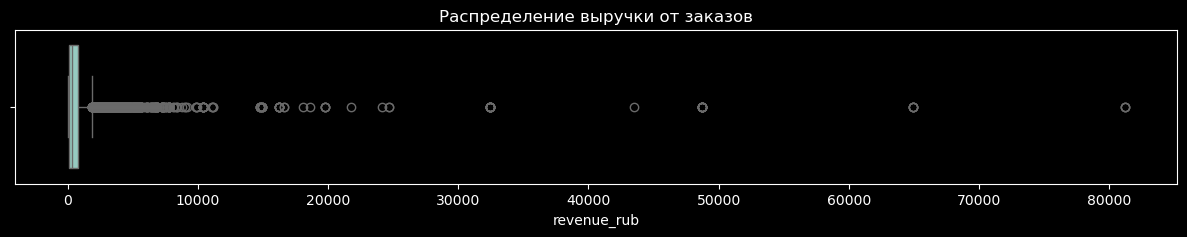

In [53]:
plt.figure(figsize=(15, 2))
sns.boxplot(x=df['revenue_rub'], orient='h')
plt.title('Распределение выручки от заказов')
plt.show()

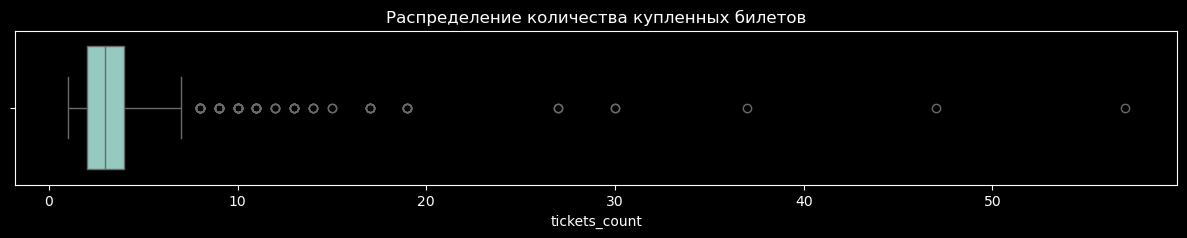

In [54]:
plt.figure(figsize=(15, 2))
sns.boxplot(x=df['tickets_count'], orient='h')
plt.title('Распределение количества купленных билетов')
plt.show()

Удалим значения выше 99 процентиля в столбце с выручкой и билетами

In [56]:
q99 = df['revenue_rub'].quantile(0.99)

In [57]:
df = df[df['revenue_rub'] <= q99].copy()

In [58]:
q99 = df['tickets_count'].quantile(0.99)

In [59]:
df = df[df['tickets_count'] <= q99].copy()

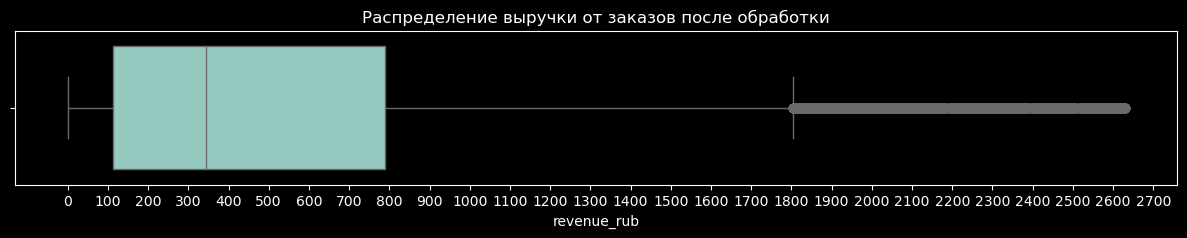

In [60]:
plt.figure(figsize=(15, 2))
sns.boxplot(x=df['revenue_rub'], orient='h')
plt.title('Распределение выручки от заказов после обработки')
plt.xticks(np.arange(0, df['revenue_rub'].max() + 100, 100))
plt.show()

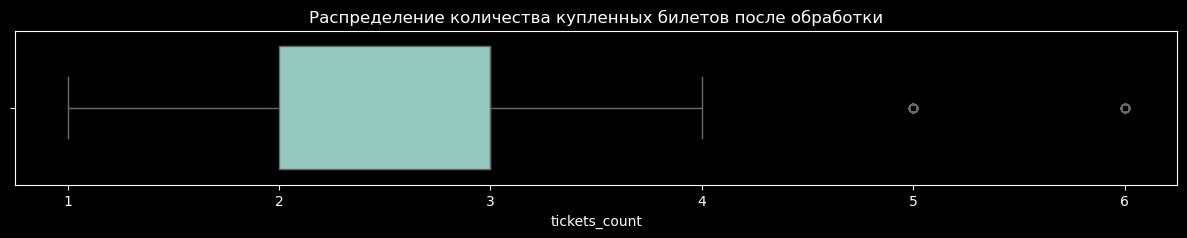

In [61]:
plt.figure(figsize=(15, 2))
sns.boxplot(x=df['tickets_count'], orient='h')
plt.title('Распределение количества купленных билетов после обработки')
plt.show()

Проверим данные на дубликаты

In [63]:
df.duplicated().sum()

0

Явных дубликатов нет, посморим количество неявных дубликатов

In [65]:
df.duplicated(subset=['user_id', 'event_id', 'venue_id', 'created_dt_msk', 'tickets_count', 
    'total_rub']).sum()

52536

In [66]:
dupl_subsets = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'total_rub', 'revenue_rub', 'event_name', 'event_type_description',
       'event_type_main', 'organizers', 'region_name', 'city_name', 'city_id',
       'venue_id', 'venue_name', 'venue_address']
df.duplicated(subset=dupl_subsets).sum()

30

Посмотрим подробнее как выглядят эти строки

In [68]:
df[df.duplicated(subset=dupl_subsets, keep=False)].sort_values(['user_id', 'event_id', 'created_dt_msk'])

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
11759,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
11760,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
57173,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036,1656,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"
57176,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036,1656,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"
83932,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76,3094,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2"
83937,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76,3094,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2"
148347,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,...,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21,2155,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432"
148351,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,...,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21,2155,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432"
154042,5372628,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2,2795,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"
154045,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2,2795,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"


Вероятно это ошибки при броннировании или оплате. Т.к. количество небольшое, то удалим эти дубликаты.

In [70]:
df.drop_duplicates(subset=dupl_subsets, inplace=True)

Создадим три столбца для дальнейшего анализа:
- `one_ticket_revenue_rub` - выручка с продажи одного билета на мероприятие.
- `month` - выделим месяц оформления заказа
- `season` - создадим столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'

In [72]:
df['one_ticket_revenue_rub'] = (df['revenue_rub'] / df['tickets_count']).round(2)

In [73]:
df['month'] = df['created_dt_msk'].dt.month

In [74]:
df['month_name'] = df['created_dt_msk'].dt.month_name()

In [75]:
def get_season(month):
    if 3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return 'зима'
    
df['season'] = df['month'].apply(get_season)

In [76]:
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,one_ticket_revenue_rub,month,month_name,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",380.48,8,August,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",144.72,7,July,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",314.64,10,October,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",4.24,7,July,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",463.47,10,October,осень


In [77]:
df = df.reset_index()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287195 entries, 0 to 287194
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   index                   287195 non-null  int64         
 1   order_id                287195 non-null  int64         
 2   user_id                 287195 non-null  object        
 3   created_dt_msk          287195 non-null  datetime64[ns]
 4   created_ts_msk          287195 non-null  datetime64[ns]
 5   event_id                287195 non-null  int64         
 6   cinema_circuit          287195 non-null  object        
 7   age_limit               287195 non-null  int64         
 8   currency_code           287195 non-null  object        
 9   device_type_canonical   287195 non-null  object        
 10  revenue                 287195 non-null  float64       
 11  service_name            287195 non-null  object        
 12  tickets_count           287195

В итоговом датасете мы получили 287195 строк и 30 столбцов.

Уменьшим разрядность числовых столбцов

In [81]:
int_cols = ['index', 'order_id', 'event_id', 'age_limit', 'tickets_count', 'city_id', 'venue_id', 'month']
float_cols = ['revenue', 'revenue_rub', 'total_rub', 'total', 'days_since_prev', 'one_ticket_revenue_rub']

df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')

In [82]:
df.dtypes

index                              int32
order_id                           int32
user_id                           object
created_dt_msk            datetime64[ns]
created_ts_msk            datetime64[ns]
event_id                           int32
cinema_circuit                    object
age_limit                           int8
currency_code                     object
device_type_canonical             object
revenue                          float32
service_name                      object
tickets_count                       int8
total                            float64
days_since_prev                  float32
total_rub                        float64
revenue_rub                      float32
event_name                        object
event_type_description            object
event_type_main                   object
organizers                        object
region_name                       object
city_name                         object
city_id                            int32
venue_id        

Для дальнейшего анализа мы провели работу по предобработке данных:
- объединили 3 датасета в один
- сконвертировали валюту из тенге в рубли
- проверили тип данных столбцов и привели их к нужному типу
- оптимизировали типы данных для числовых столбцов
- проверили данные на наличие явных и неявных дубликатов и удалили их
- изучили пропуски в данных. Пропуски обнаружились в столбце `days_since_prev`, там они допустимы
- отфильтровали данные по 99 процентилю для столбцов с выручкой `revenue_rub` и количеством билетов `tickets_count`
- создали новые столбцы: `month`, `month_name`, `season`, `one_ticket_revenue_rub`, `total_rub`, `revenue_rub`

## 3. Исследовательский анализ данных

Исследуем пользовательскую активность 

In [86]:
df.groupby('month_name', observed=True)['order_id'].count()

month_name
August       44520
July         40377
June         33778
October      99233
September    69287
Name: order_id, dtype: int64

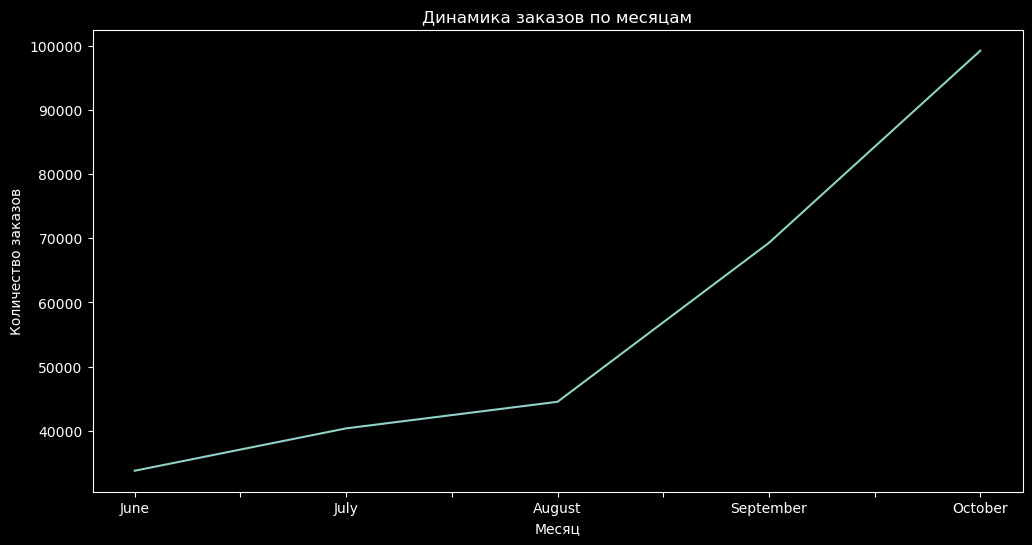

In [87]:
month_order = ['June', 'July', 'August', 'September', 'October']

df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

plt.figure(figsize=(12, 6))
df.groupby('month_name', observed=True)['order_id'].count().sort_index().plot(kind='line')
plt.title('Динамика заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Количество заказов резко возрастает осенью

Исследуем распределение количества заказов в разрезе летнего и осеннего периода

In [90]:
summer = df[df['season'] == 'лето']
autumn = df[df['season'] == 'осень']

In [91]:
summer['event_type_main'].value_counts()

event_type_main
концерты    50554
другое      32141
театр       23951
стендап      6348
спорт        3001
выставки     2407
ёлки          273
Name: count, dtype: int64

In [92]:
autumn['event_type_main'].value_counts()

event_type_main
концерты    62894
театр       42755
другое      33001
спорт       18851
стендап      6924
выставки     2402
ёлки         1693
Name: count, dtype: int64

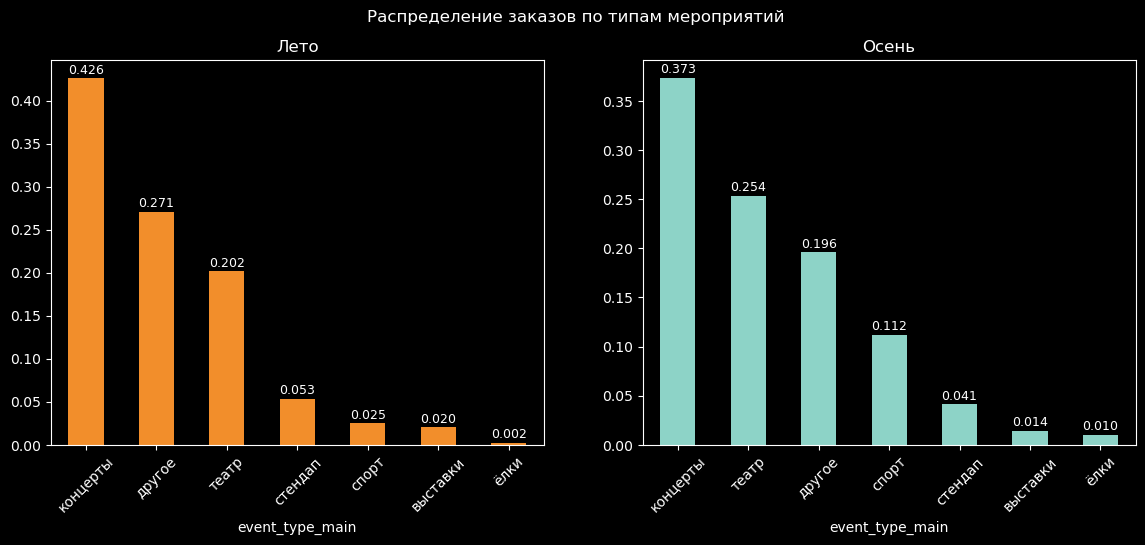

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

summer_counts = summer['event_type_main'].value_counts(normalize=True)
summer_counts.plot(kind='bar', ax=axes[0], color='#f28e2b', rot=45)

autumn_counts = autumn['event_type_main'].value_counts(normalize=True)
autumn_counts.plot(kind='bar', ax=axes[1], rot=45)

for ax, counts in zip(axes, [summer_counts, autumn_counts]):
    for i, v in enumerate(counts):
        ax.text(i, v + 0.002, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

axes[0].set_title('Лето')
axes[1].set_title('Осень')
plt.suptitle('Распределение заказов по типам мероприятий')
plt.show()

Концерты, театр и другое лидируют в каждый период. Театр и другое только меняют второе и третье место в зависимости о периода. 
После топовых позиций следубщее место летом занимает стендап, а зимой спорт.
Посмотрим на распределение в разрезе типа устройства.

In [95]:
summer['device_type_canonical'].value_counts()

device_type_canonical
mobile     95756
desktop    22919
Name: count, dtype: int64

In [96]:
autumn['device_type_canonical'].value_counts()

device_type_canonical
mobile     134222
desktop     34298
Name: count, dtype: int64

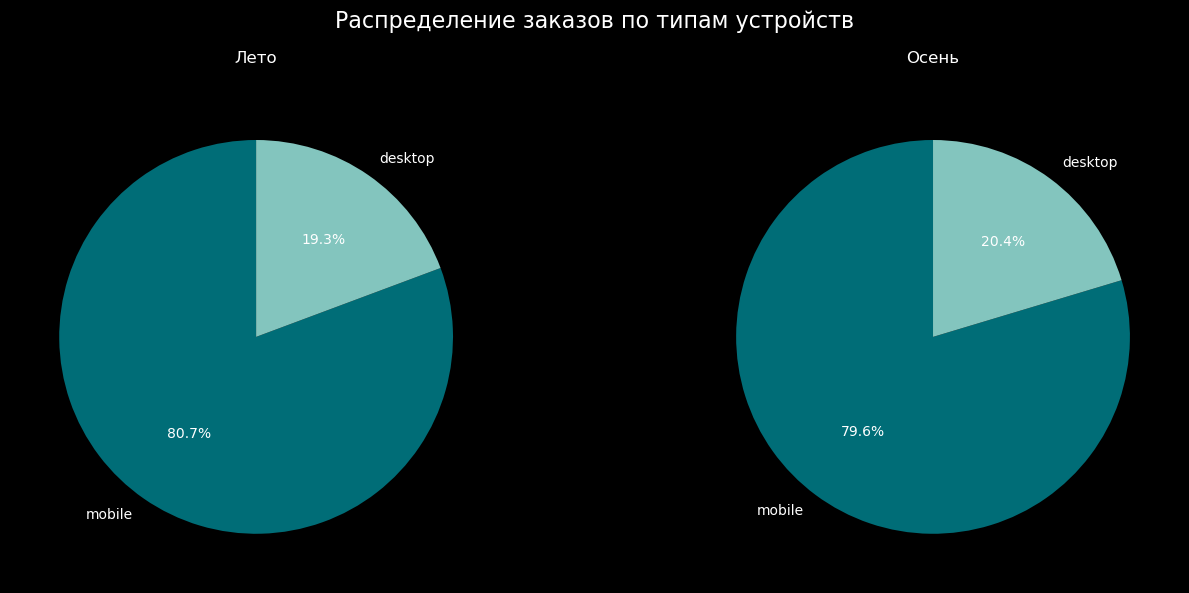

In [97]:
summer_type = summer['device_type_canonical'].value_counts(normalize=True)
autumn_type = autumn['device_type_canonical'].value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Распределение заказов по типам устройств', fontsize=16)

ax1.pie(summer_type, 
        labels=summer_type.index,
        autopct='%1.1f%%',
        colors=['#006d77', '#83c5be'],
        startangle=90)
ax1.set_title('Лето', pad=20)

ax2.pie(autumn_type, 
        labels=autumn_type.index,
        autopct='%1.1f%%',
        colors=['#006d77', '#83c5be'],
        startangle=90)
ax2.set_title('Осень', pad=20)

plt.tight_layout()
plt.show()

Заказы по осеннему и летнему периоду распределены очень схоже в процентном соотношении. 

Исследуем распределение заказов в разрезе возрастного рейтинга.

In [99]:
summer.groupby('age_limit')['order_id'].count().sort_values(ascending=False)

age_limit
16    33759
12    24126
6     21760
0     21255
18    17775
Name: order_id, dtype: int64

In [100]:
autumn.groupby('age_limit')['order_id'].count().sort_values(ascending=False)

age_limit
16    44219
0     39691
12    37269
6     29811
18    17530
Name: order_id, dtype: int64

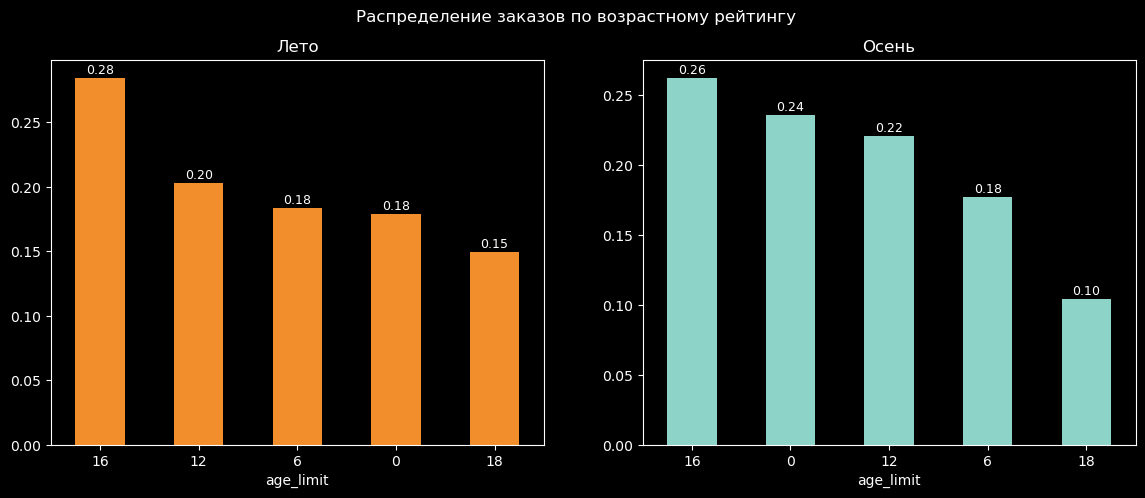

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

summer_counts = summer['age_limit'].value_counts(normalize=True)
summer_counts.plot(kind='bar', ax=axes[0], color='#f28e2b', rot=0)

autumn_counts = autumn['age_limit'].value_counts(normalize=True)
autumn_counts.plot(kind='bar', ax=axes[1], rot=0)

for ax, counts in zip(axes, [summer_counts, autumn_counts]):
    for i, v in enumerate(counts):
        ax.text(i, v + 0.001, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_title('Лето')
axes[1].set_title('Осень')
plt.suptitle('Распределение заказов по возрастному рейтингу')
plt.show()

Летом и осенью первое место занимает рейтинг `16 лет`. Второе место летом занимает категория `12 лет`, а осенью второе место занимает категория `0 лет`. И летом и осенью меньше всего в категории `18 лет`.

Изуим распределение средней стоимости за один билет.

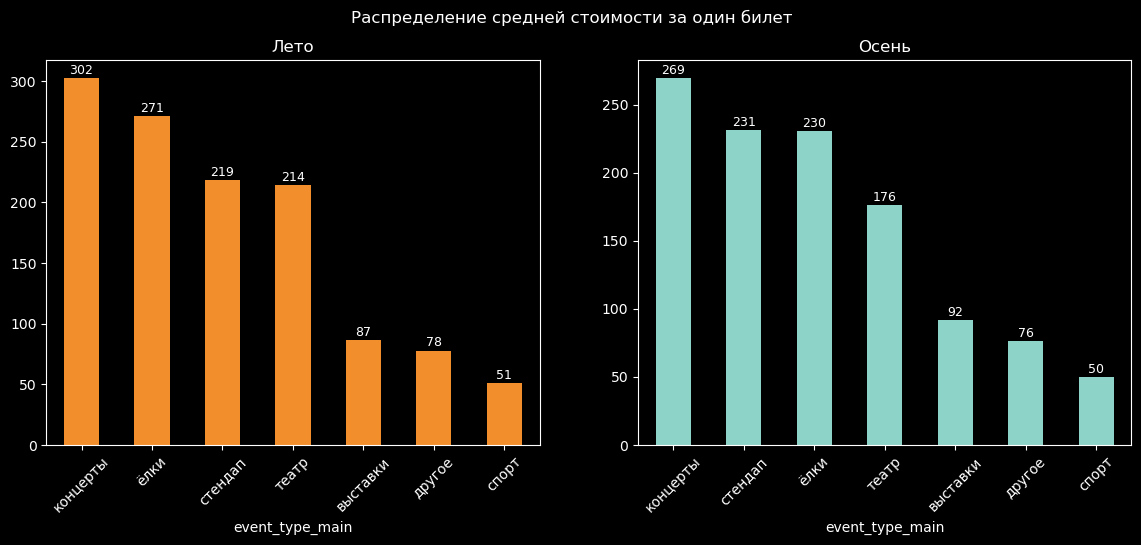

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

summer_means = summer.groupby('event_type_main')['one_ticket_revenue_rub'].mean().sort_values(ascending=False)
summer_means.plot(kind='bar', ax=axes[0], color='#f28e2b', rot=45)

autumn_means = autumn.groupby('event_type_main')['one_ticket_revenue_rub'].mean().sort_values(ascending=False)
autumn_means.plot(kind='bar', ax=axes[1], rot=45)

for ax, means in zip(axes, [summer_means, autumn_means]):
    for i, v in enumerate(means):
        ax.text(i, v + 1, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

axes[0].set_title('Лето')
axes[1].set_title('Осень')
plt.suptitle('Распределение средней стоимости за один билет')
plt.show()

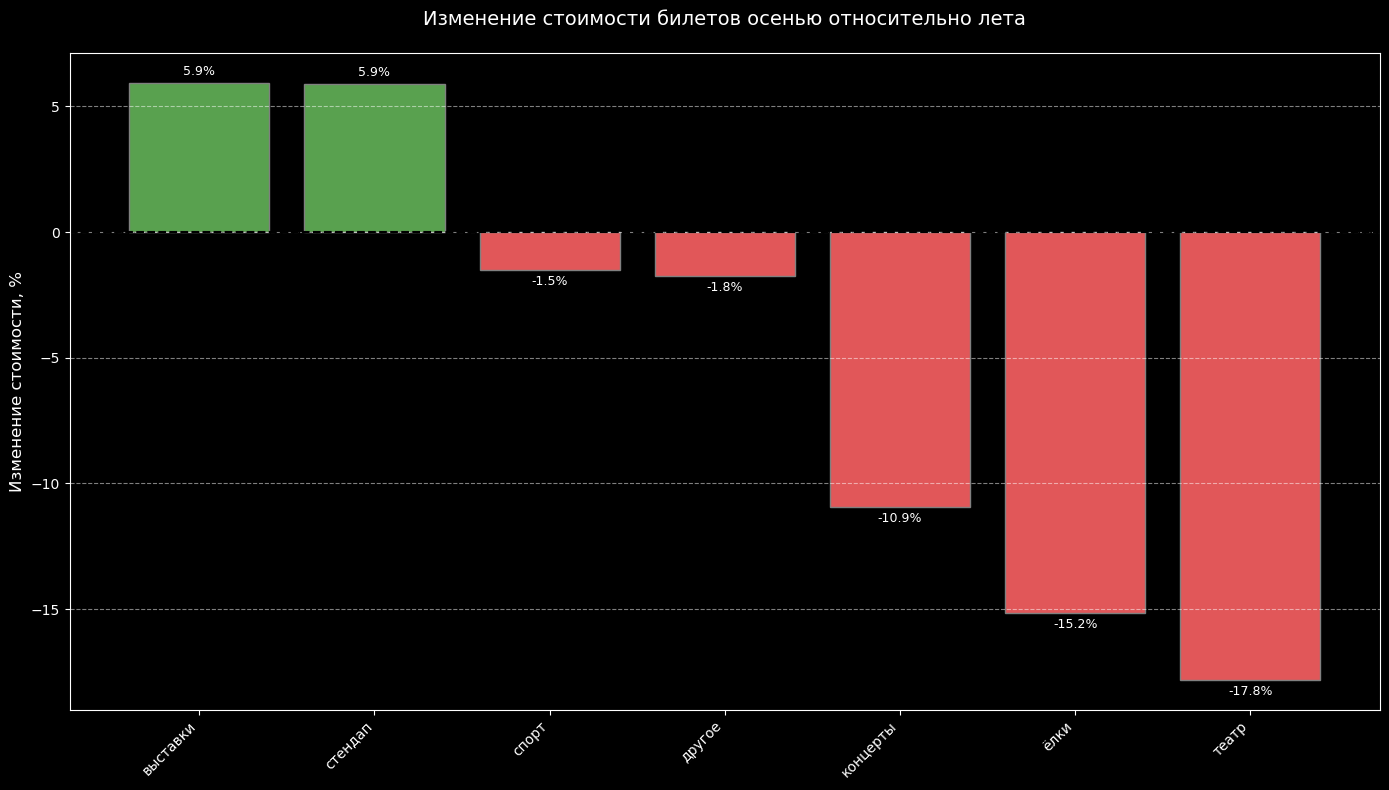

In [104]:
plt.figure(figsize=(14, 8))

changes = (autumn.groupby('event_type_main')['one_ticket_revenue_rub'].mean() / 
          summer.groupby('event_type_main')['one_ticket_revenue_rub'].mean() - 1) * 100
changes = changes.sort_values(ascending=False)

bars = plt.bar(
    changes.index,
    changes,
    color=changes.apply(lambda x: '#59a14f' if x >=0 else '#e15759'),
    edgecolor='grey'
)

plt.title('Изменение стоимости билетов осенью относительно лета', pad=20, fontsize=14)
plt.ylabel('Изменение стоимости, %', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + (0.2 if height >=0 else -0.2),
        f'{height:.1f}%',
        ha='center',
        va='bottom' if height >=0 else 'top',
        fontsize=9
    )

plt.tight_layout()
plt.show()

Осенью средняя стоимость билета на основные типы мероприятий ниже чем летом. Только две категории показывают рост:выставки и стендап.

Изучим активность пользователей осенью подробне, создадим сводную таблицу

In [107]:
daily_autumn_stats = autumn.groupby('created_dt_msk').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'revenue_rub': 'sum', 
    'tickets_count': 'sum'
})

daily_autumn_stats.columns = ['total_orders', 'dau', 'total_revenue', 'total_tickets']

daily_autumn_stats.head()

,total_orders,dau,total_revenue,total_tickets
created_dt_msk,,,,
2024-09-01,1331,565,7.365811e+05,3733
2024-09-02,1376,573,7.035391e+05,3695
2024-09-03,5095,777,1.158925e+06,15255
2024-09-04,1760,683,8.608682e+05,4772
2024-09-05,1938,739,9.892268e+05,5175


Добавим столбцы с средним числом заказов на одного пользователя и средней стоимости одного билета

In [109]:
daily_autumn_stats['orders_per_user'] = daily_autumn_stats['total_orders'] / daily_autumn_stats['dau'] 

In [110]:
daily_autumn_stats['avg_ticket_price'] = daily_autumn_stats['total_revenue'] / daily_autumn_stats['total_tickets']

Создадим столбец с днем недели

In [112]:
daily_autumn_stats['day_of_week'] = daily_autumn_stats.index.day_name()

In [113]:
daily_autumn_stats.head()

,total_orders,dau,total_revenue,total_tickets,orders_per_user,avg_ticket_price,day_of_week
created_dt_msk,,,,,,,
2024-09-01,1331,565,7.365811e+05,3733,2.355752,197.316116,Sunday
2024-09-02,1376,573,7.035391e+05,3695,2.401396,190.402994,Monday
2024-09-03,5095,777,1.158925e+06,15255,6.557272,75.970166,Tuesday
2024-09-04,1760,683,8.608682e+05,4772,2.576867,180.399872,Wednesday
2024-09-05,1938,739,9.892268e+05,5175,2.622463,191.154940,Thursday


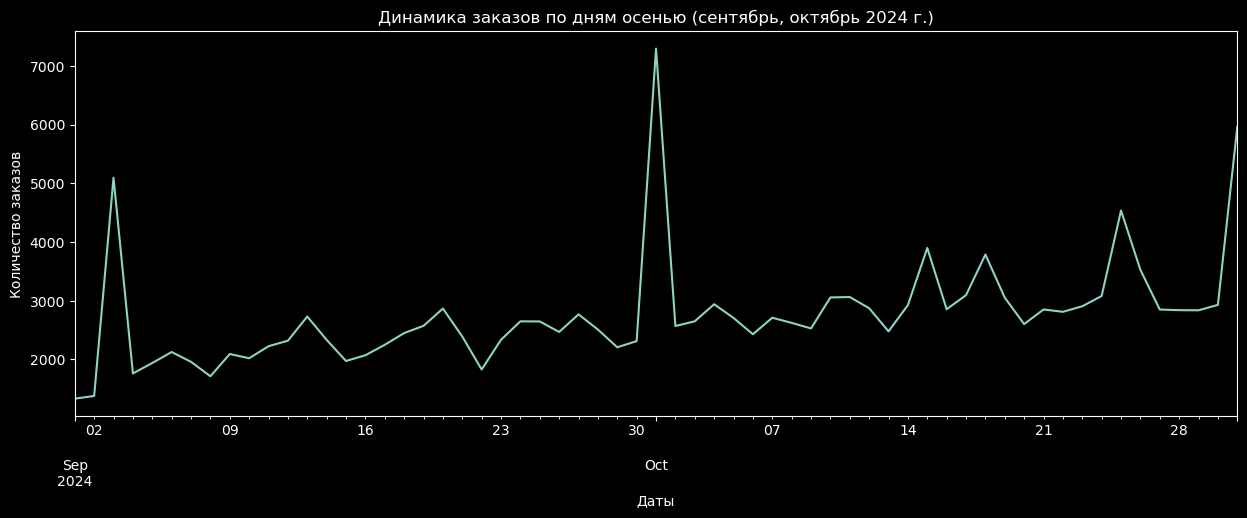

In [114]:
plt.figure(figsize=(15, 5))
daily_autumn_stats['total_orders'].plot()

plt.title('Динамика заказов по дням осенью (сентябрь, октябрь 2024 г.)')
plt.ylabel('Количество заказов')
plt.xlabel('Даты')
plt.show()

По графику заказов видео тренд роста заказов с несколькими пиками

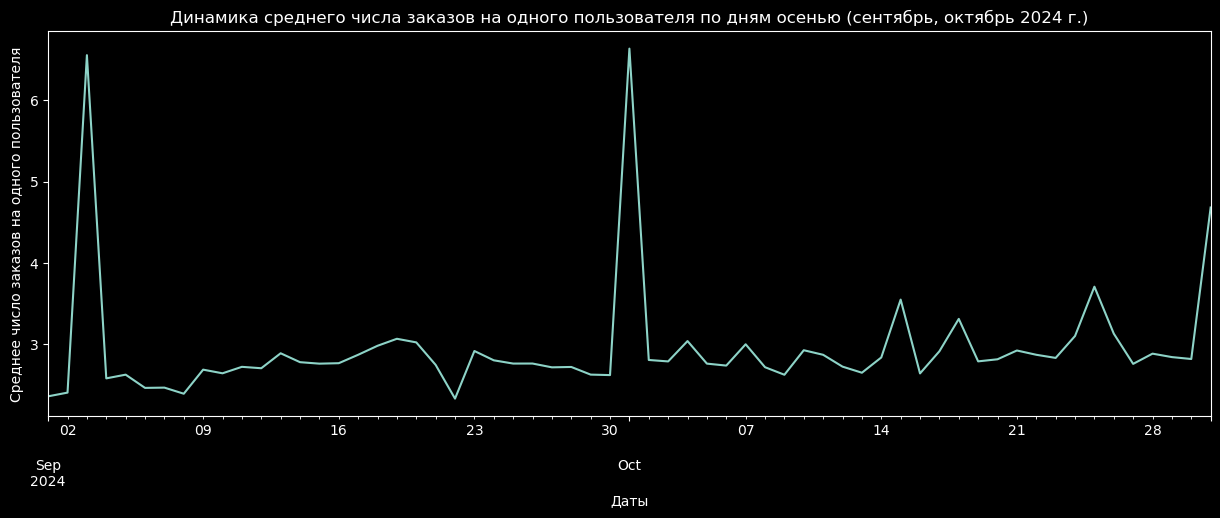

In [116]:
plt.figure(figsize=(15, 5))
daily_autumn_stats['orders_per_user'].plot()

plt.title('Динамика среднего числа заказов на одного пользователя по дням осенью (сентябрь, октябрь 2024 г.)')
plt.ylabel('Cреднеe число заказов на одного пользователя')
plt.xlabel('Даты')
plt.show()

График среднего числа заказов на пользователя также показывает небольшой рост в течение двух месяцев, а также те же пики резкого роста.

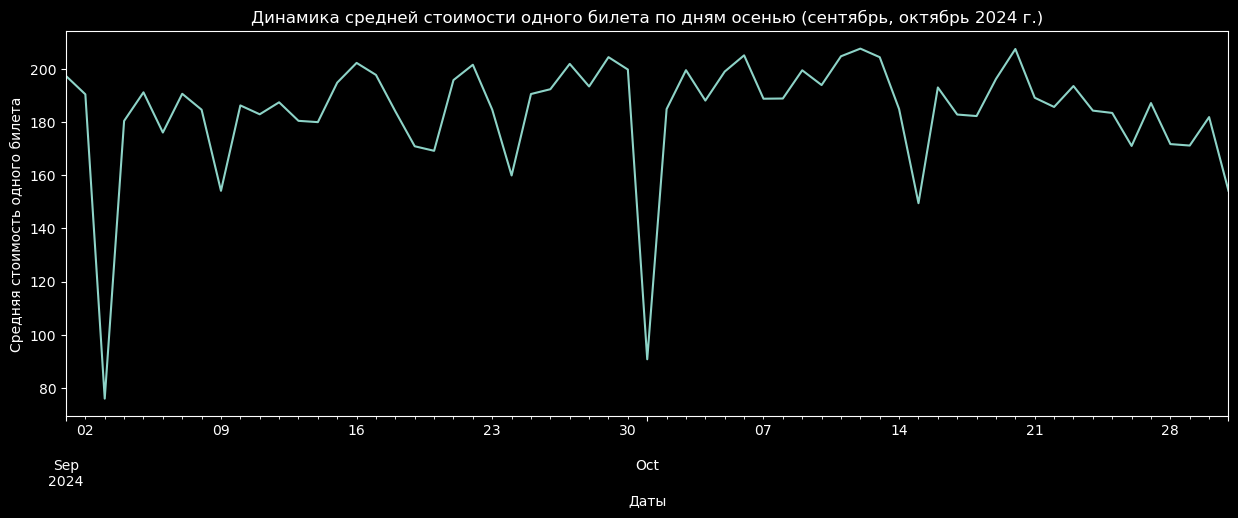

In [118]:
plt.figure(figsize=(15, 5))
daily_autumn_stats['avg_ticket_price'].plot()

plt.title('Динамика средней стоимости одного билета по дням осенью (сентябрь, октябрь 2024 г.)')
plt.ylabel('Средняя стоимость одного билета')
plt.xlabel('Даты')
plt.show()

Средння стоимость показывает "обратный" график графику количества заказов. Вероятно в жэти дни стоимость билетов была ниже и поэтому количество заказов выше.

Изучим количество активных пользователей осенью

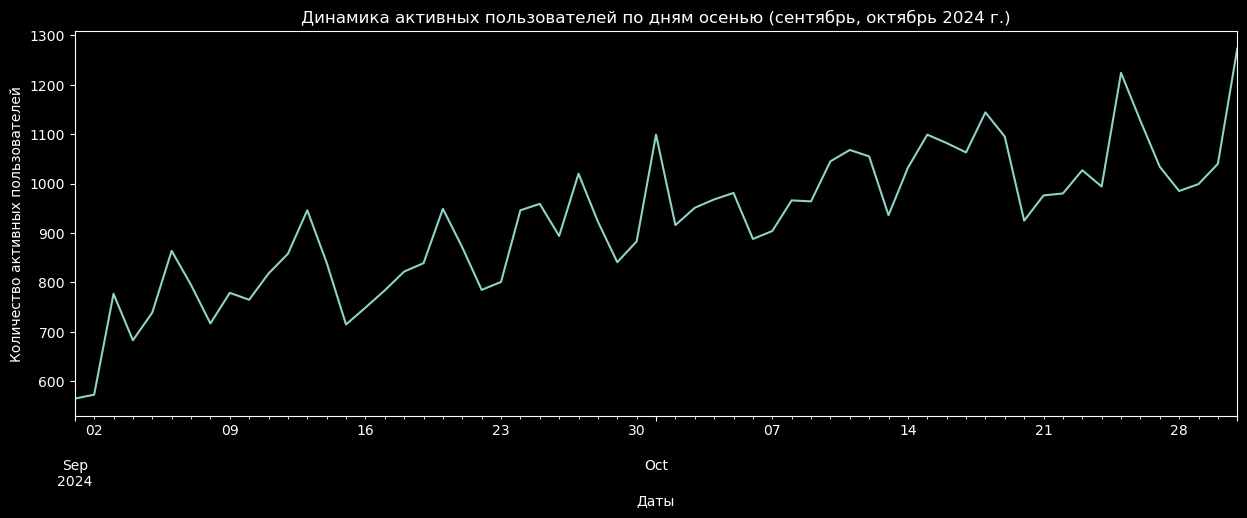

In [121]:
plt.figure(figsize=(15, 5))
daily_autumn_stats['dau'].plot()

plt.title('Динамика активных пользователей по дням осенью (сентябрь, октябрь 2024 г.)')
plt.ylabel('Количество активных пользователей')
plt.xlabel('Даты')
plt.show()

Осенью виден тренд роста количества пользователей.

Исследуем как распределяются заказы по дня недели.

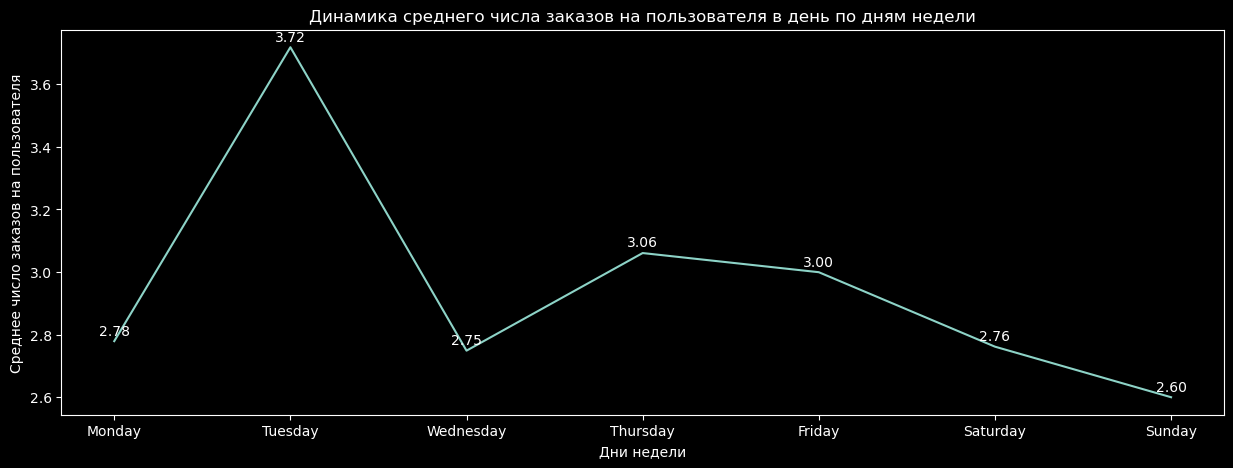

In [124]:
plt.figure(figsize=(15, 5))

weekday_stats = daily_autumn_stats.groupby('day_of_week')['orders_per_user'].mean()

weekday_stats = weekday_stats.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

weekday_stats.plot()

for i, v in enumerate(weekday_stats.values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
    
plt.title('Динамика среднего числа заказов на пользователя в день по дням недели')
plt.ylabel('Среднее число заказов на пользователя')
plt.xlabel('Дни недели')
plt.show()

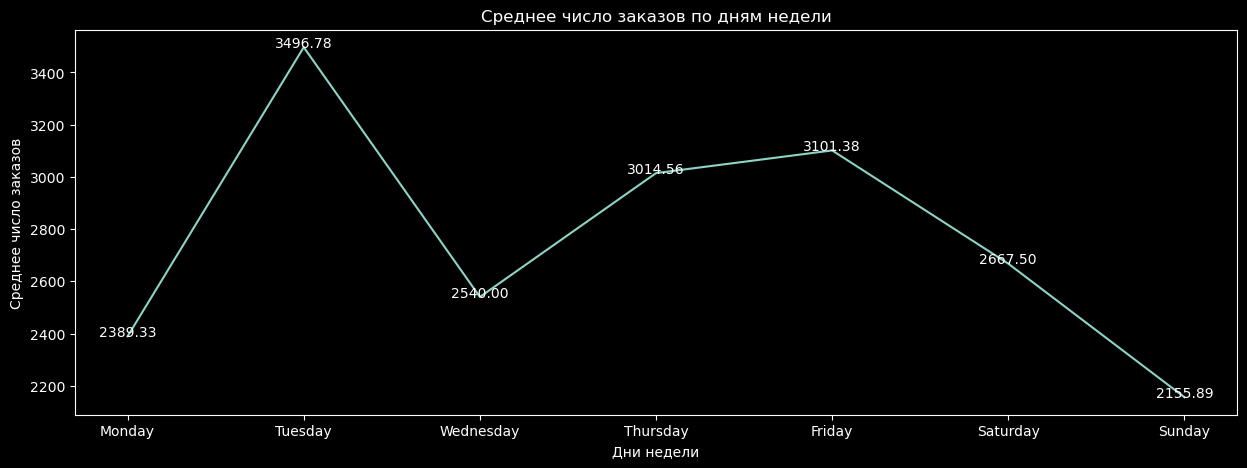

In [125]:
plt.figure(figsize=(15, 5))

weekday_stats = daily_autumn_stats.groupby('day_of_week')['total_orders'].mean()

weekday_stats = weekday_stats.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

weekday_stats.plot()

for i, v in enumerate(weekday_stats.values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

plt.title('Среднее число заказов по дням недели')
plt.ylabel('Среднее число заказов')
plt.xlabel('Дни недели')
plt.show()

Число заказов имеет очень высокий пик во вторник, меньше всего заказов в выходные.

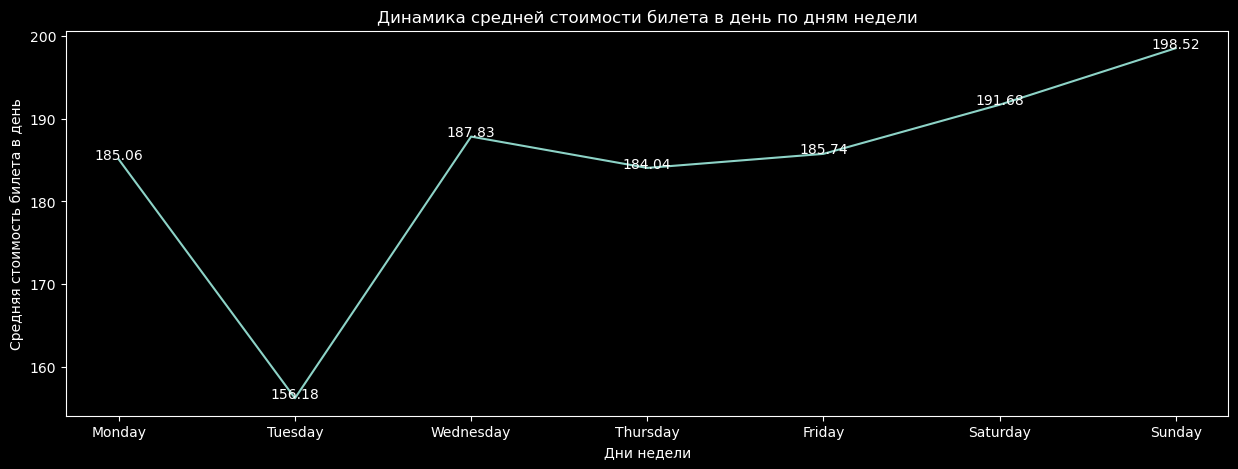

In [127]:
plt.figure(figsize=(15, 5))

weekday_stats = daily_autumn_stats.groupby('day_of_week')['avg_ticket_price'].mean()

weekday_stats = weekday_stats.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

weekday_stats.plot()

for i, v in enumerate(weekday_stats.values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

plt.title('Динамика средней стоимости билета в день по дням недели')
plt.ylabel('Средняя стоимость билета в день')
plt.xlabel('Дни недели')
plt.show()

А средняя стоимость билета имеет обратное отображение количеству заказов. дешевле всего билеты во вторник, дороже всего в выходные.

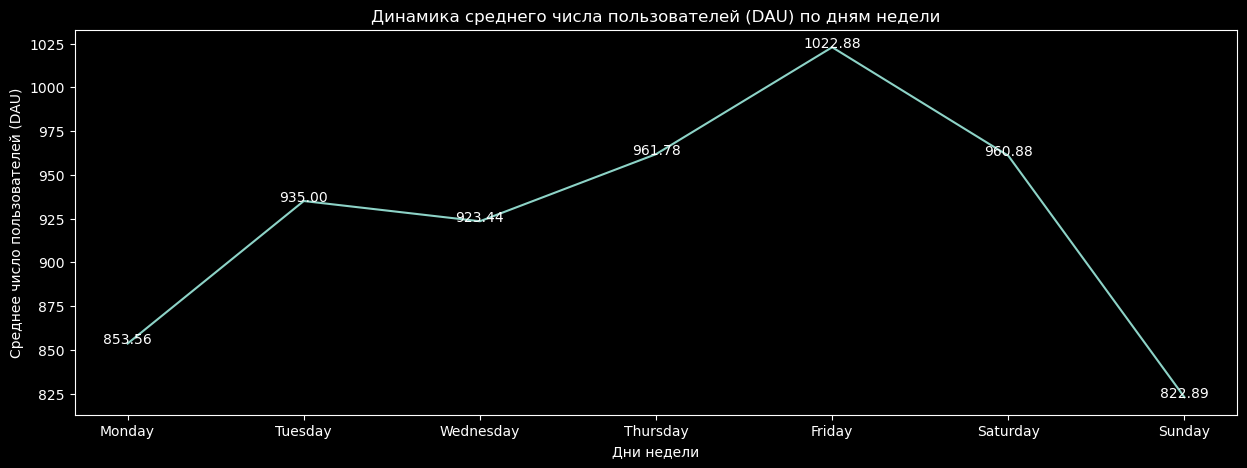

In [129]:
plt.figure(figsize=(15, 5))

weekday_stats = daily_autumn_stats.groupby('day_of_week')['dau'].mean()

weekday_stats = weekday_stats.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

weekday_stats.plot()

for i, v in enumerate(weekday_stats.values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

plt.title('Динамика среднего числа пользователей (DAU) по дням недели')
plt.ylabel('Среднее число пользователей (DAU)')
plt.xlabel('Дни недели')
plt.show()

Количество активных пользователей растет в течение недели и имеет резкий спад в выходные дни.

Посмотрим как распределяются заказы, пользователи и средняя цена по категориям выходные\будни

<Figure size 1000x600 with 0 Axes>

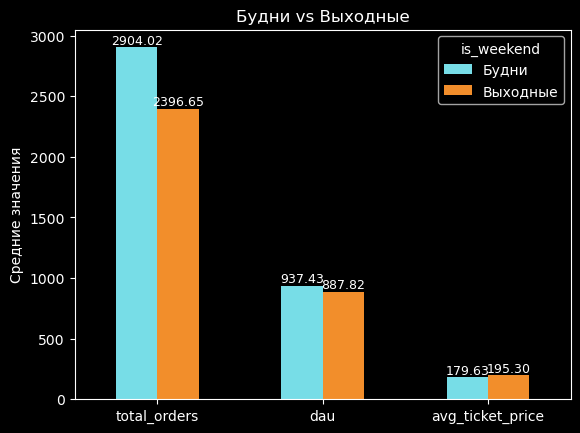

In [132]:
daily_autumn_stats['is_weekend'] = daily_autumn_stats.index.dayofweek >= 5

weekday_vs_weekend = daily_autumn_stats.groupby('is_weekend').agg({
    'total_orders': 'mean',
    'dau': 'mean',
    'avg_ticket_price': 'mean'
}).rename(index={False: 'Будни', True: 'Выходные'})

plt.figure(figsize=(10, 6))
bars = weekday_vs_weekend.T.plot(kind='bar', rot=0, color=['#77dde7', '#f28e2b'])

for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.title('Будни vs Выходные')
plt.ylabel('Средние значения')
plt.show()

Среднее количество активных пользователей и среднее количество заказов в будни выше, 2904 заказа в будни против 2396 заказов в выходные. А средняя стоимость билета в выходные выше, чем в будни.

- Пользовательская активность выше в будние дни, особенно по вторникам и пятницам.
- Выходные менее активны по числу заказов, но сопровождаются ростом средней цены билета.
- Чем дешевле билет, тем больше заказов.

Исследуем как события распределены по регионам и партнёрам

Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. 

In [137]:
region_stats = autumn.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'),  
    total_orders=('order_id', 'count'),     
    total_revenue=('revenue_rub', 'sum')    
).sort_values('total_revenue', ascending=False)

region_stats['events_share'] = region_stats['unique_events'] / region_stats['unique_events'].sum() * 100
region_stats['orders_share'] = region_stats['total_orders'] / region_stats['total_orders'].sum() * 100
region_stats['revenue_share'] = region_stats['total_revenue'] / region_stats['total_revenue'].sum() * 100

region_stats.head(10)

,unique_events,total_orders,total_revenue,events_share,orders_share,revenue_share
region_name,,,,,,
Каменевский регион,3914,46708,2.869562e+07,24.712716,27.716592,34.864216
Североярская область,2608,20649,1.048261e+07,16.466726,12.253145,12.736023
Озернинский край,296,7524,6.750591e+06,1.868923,4.464752,8.201743
Широковская область,796,8648,4.227829e+06,5.025887,5.131735,5.136671
Малиновоярский округ,137,4546,3.713480e+06,0.865008,2.697603,4.511754
Медовская область,368,12042,2.344737e+06,2.323526,7.145739,2.848777
Светополянский округ,762,4770,1.986373e+06,4.811214,2.830525,2.413377
Яблоневская область,431,4195,1.943334e+06,2.721303,2.489319,2.361086
Речиновская область,529,3565,1.743276e+06,3.340068,2.115476,2.118022


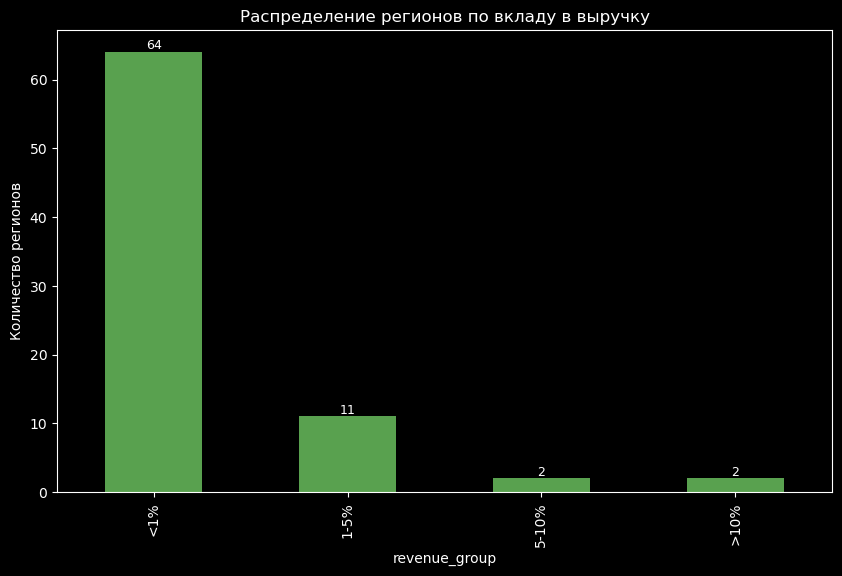

In [138]:
bins = [0, 1, 5, 10, 100]
labels = ['<1%', '1-5%', '5-10%', '>10%']
region_stats['revenue_group'] = pd.cut(
    region_stats['revenue_share'], 
    bins=bins, 
    labels=labels
)

group_distribution = region_stats['revenue_group'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = group_distribution.plot(kind='bar', color='#59a14f')

for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f'{height}', ha='center', va='bottom', fontsize=9)

plt.title('Распределение регионов по вкладу в выручку')
plt.ylabel('Количество регионов')
plt.show()

Наибольший вклад в выручку приносят Каменевский регион (34.86%), Североярская область (12.74%) и Озернинский край (8.2%). Эти три региона приносят более 50% всей выручки. В первых двух регионаз также наблюдается самое большое разнообразие мероприятий.

Посмотрим как события распределены среди партнеров.

In [141]:
partner_stats = autumn.groupby('service_name').agg(
    unique_events=('event_id', 'nunique'), 
    total_orders=('order_id', 'count'),     
    total_revenue=('revenue_rub', 'sum')    
).sort_values('total_revenue', ascending=False)


partner_stats['revenue_share'] = partner_stats['total_revenue'] / partner_stats['total_revenue'].sum() * 100
partner_stats['orders_share'] = partner_stats['total_orders'] / partner_stats['total_orders'].sum() * 100
partner_stats['revenue_share'] = partner_stats['total_revenue'] / partner_stats['total_revenue'].sum() * 100

partner_stats.head(10)

,unique_events,total_orders,total_revenue,revenue_share,orders_share
service_name,,,,,
Билеты без проблем,2834,32400,12459131.00,15.137429,19.226205
Мой билет,1002,19400,10841900.00,13.172547,11.511987
Облачко,1409,15478,10611052.00,12.892075,9.184667
Лови билет!,3613,25780,10412266.00,12.650557,15.297887
Весь в билетах,600,9427,9379749.00,11.396083,5.593995
Билеты в руки,2457,25646,7619515.50,9.257458,15.218372
Край билетов,193,3004,3037065.25,3.689933,1.782578
Яблоко,537,3473,2763332.25,3.357357,2.060883
Прачечная,728,5798,2548310.50,3.096112,3.440541


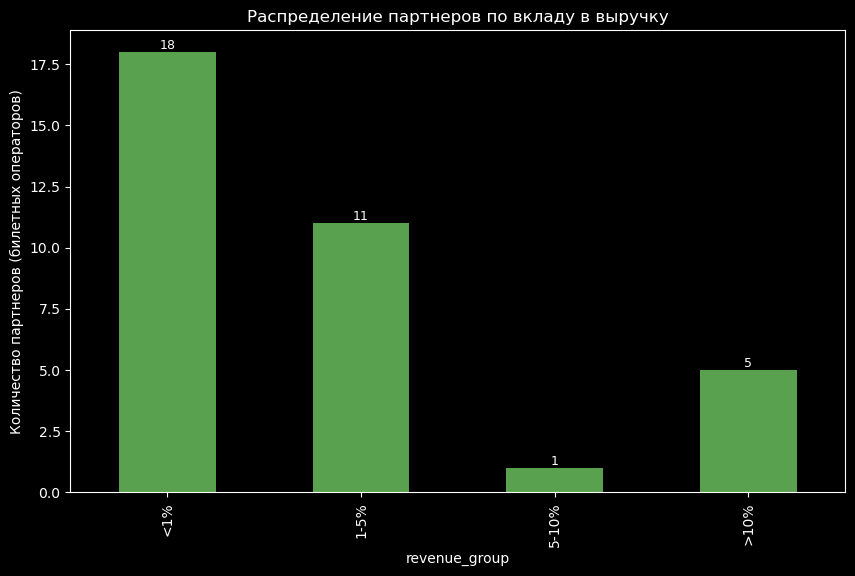

In [142]:
bins = [0, 1, 5, 10, 100]
labels = ['<1%', '1-5%', '5-10%', '>10%']
partner_stats['revenue_group'] = pd.cut(
    partner_stats['revenue_share'], 
    bins=bins, 
    labels=labels
)

group_distribution = partner_stats['revenue_group'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = group_distribution.plot(kind='bar', color='#59a14f')

for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f'{height}', ha='center', va='bottom', fontsize=9)

plt.title('Распределение партнеров по вкладу в выручку')
plt.ylabel('Количество партнеров (билетных операторов)')
plt.show()

Наиболее активные следующие партнеры: Билеты без проблем (15.14%), Мой билет (13.17%), Облачко (12.89%), Лови билет! (12.65%), Весь в билетах (11.39%), Билеты в руки (9.25%). Более 60 процентов выручки распределены среди этих шести партнеров. Наиболее разнообразные мероприятия у Лови билет! и Билеты без проблем.

## 4. Статистический анализ данных

Проверим гипотезы относительно активности пользователей мобильных и стационарных устройств. 

- Нулевая гипотеза (Н0): Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователями стационарных устройств. 
- Альтернативная гипотеза (Н1): Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Разобьем пользователей на две группы по категории устройств.

In [148]:
mobile_df = autumn[autumn['device_type_canonical'] == 'mobile']
desktop_df = autumn[autumn['device_type_canonical'] == 'desktop']

In [149]:
orders_mobile = mobile_df.groupby('user_id')['order_id'].count()
orders_desktop = desktop_df.groupby('user_id')['order_id'].count()

In [150]:
days_mobile = mobile_df['days_since_prev'].dropna()
days_desktop = desktop_df['days_since_prev'].dropna()

Изучим как распределены данные.

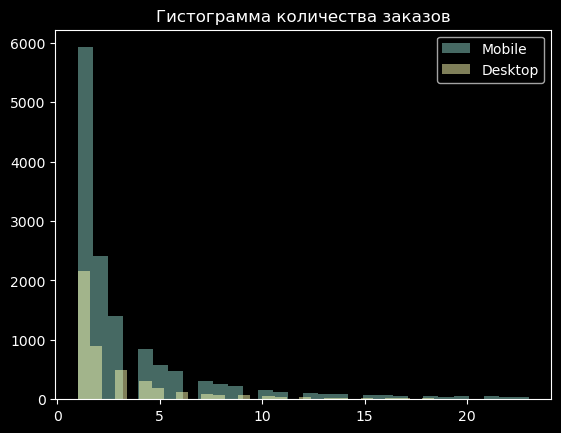

In [152]:
plt.hist(orders_mobile[orders_mobile < orders_mobile.quantile(0.95)], bins=30, alpha=0.5, label='Mobile')
plt.hist(orders_desktop[orders_desktop < orders_desktop.quantile(0.95)], bins=30, alpha=0.5, label='Desktop')
plt.legend()
plt.title('Гистограмма количества заказов')
plt.show()

In [153]:
orders_mobile.describe()

count    14185.000000
mean         9.462249
std         68.015374
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4328.000000
Name: order_id, dtype: float64

In [154]:
orders_desktop.describe()

count    4871.000000
mean        7.041265
std        35.902076
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1493.000000
Name: order_id, dtype: float64

Данные распределены не нормльно, сильно скошены вправо, имеется длинный хвост. Для проверки гипотезы будем использовать тест Манна-Уитни. Этот тест позволяет сравнить медиану двух независимых выборок и определить, есть ли статистически значимая разница между ними.

In [156]:
t_stat, p_value = mannwhitneyu(orders_mobile, orders_desktop, alternative='greater')

p_value

3.5773022768478113e-07

p_value меньше критического уровня alpha=0.05. Отвергаем нулевую гипотезу. У мобильных пользователей значимо больше заказов на одного пользователя.

Проверим вторую гипотезу

- Нулевая гипотеза (Н0):Среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями стационарных устройств.
- Альтернативная гипотеза (Н1): Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Посмотрим как распределены данные

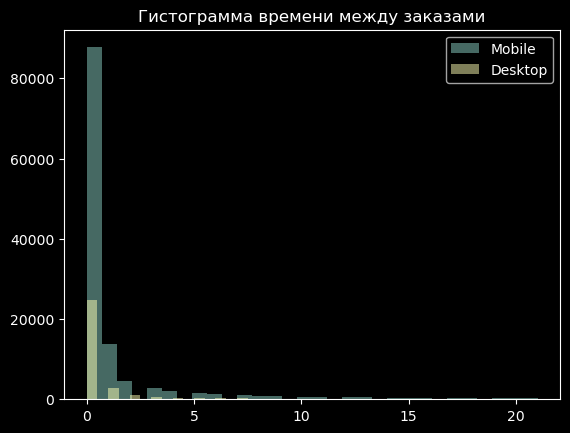

In [161]:
plt.hist(days_mobile[days_mobile < days_mobile.quantile(0.95)], bins=30, alpha=0.5, label='Mobile')
plt.hist(days_desktop[days_desktop < days_desktop.quantile(0.95)], bins=30, alpha=0.5, label='Desktop')
plt.legend()
plt.title('Гистограмма времени между заказами')
plt.show()

In [162]:
days_mobile.describe()

count    127237.000000
mean          3.779915
std          13.382677
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

In [163]:
days_desktop.describe()

count    32937.000000
mean         3.027962
std         12.101892
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        146.000000
Name: days_since_prev, dtype: float64

Данные также как и в прошлой выборке распределены не нормльно, сильно скошены вправо, имеется длинный хвост. Для проверки гипотезы будем использовать тест Манна-Уитни.

In [165]:
t_stat, p_value = mannwhitneyu(days_mobile, days_desktop, alternative='greater')

p_value

2.0467689463575417e-92

p_value меньше критического уровня alpha=0.05. Отвергаем нулевую гипотезу. Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Пользователи мобильных устройств более активны: они совершают больше заказов, но делают это с большим интервалом времени между заказами по сравнению с пользователями стационарных устройств. 

Рекомендации: для пользователей мобильного приложения возможно оптимизировать UX/UI для ускорения повторных покупок, для пользователей пк стимулировать увеличение среднего чека, например «Добавьте еще один билет со скидкой 10%».

##  5. Общий вывод и рекомендации

Были загружены данные трех датасетов: `final_tickets_orders_df.csv`, `final_tickets_events_df.csv` и `final_tickets_tenge_df`, в первом содержалась информация о заказах билетов на мероприятия, во втором о мероприятиях, в третьем о курсе тенге к рублю. В дальнейшем датасеты были объединены в единый датафрейм.

Для дальнейшего анализа мы провели работу по предобработке данных:
- проверили названия столбцов датафрейма
- изменили тип данных в столбцах с датой
- проверили данные на пропуски
- проверили данные на наличие явных и неявных дубликатов и удалили их
- оптимизировали типы данных для числовых столбцов
- создали новые столбцы: `month`, `month_name`, `season`, `one_ticket_revenue_rub`, `total_rub`, `revenue_rub`

Провели исследовательский анализ данных:
- исследовали пользовательскую активность 
- исследовали распределение количества заказов в разрезе летнего и осеннего периода по нескольким направлениям: по типу устройств, по типу мероприятий, по возрастному рейтингу, по средней стоимости билета
- исследовали динамику заказов, среднюю стоимость, активных пользователей осенью
- исследовали динамику заказов, среднюю стоимость, активных пользователей по дням недели
- исследовали распределение заказов, средней стоимости, активных пользователей по выходным и будням
- исследовали топ регионов по выручке
- исследовали топ партнеров по выручке

Провели статистический анализ данных:
- Проверим гипотезы относительно активности пользователей мобильных и стационарных устройств. 

#### Итоговые выводы и рекомендации:
Типы мероприятий:
- Концерты и театры — самые популярные категории летом и осенью.
- В осенние месяцы доля заказов смещается в сторону театров, возможно это связано с погодными условиями и началом учебного сезона.
- Меньшую долю занимают выставки

Сезонность:
- В осенний период средняя стоимость билета стала ниже, чем летом. Только стендап и выставки показывают небольшой рост осенью.
- В выходные цена билета выше, чем в будние дни — особенно в воскресенье.
- Вторник и пятница — дни с наибольшим средним числом заказов.
- Выходные показывают снижение числа заказов, несмотря на рост стоимости билетов.
- Видна обратная зависимость между ценой и объёмом заказов: снижение цены (например, по вторникам) приводит к пикам активности.

Топы по выручке:
- Наибольший вклад в выручку приносят Каменевский регион (34.86%), Североярская область (12.74%) и Озернинский край (8.2%). Эти три региона приносят более 50% всей выручки.
- Наиболее активные следующие партнеры: Билеты без проблем (15.14%), Мой билет (13.17%), Облачко (12.89%), Лови билет! (12.65%), Весь в билетах (11.39%), Билеты в руки (9.25%). У топ-10 партнёров значительное превосходство над остальными: они генерируют львиную долю продаж

Гипотезы:
- Проведённый Mann-Whitney тест подтвердил статистически значимую разницу между пользователями мобильных устройств и пк

Рекомендации:
- Сильная недельная цикличность: спрос на билеты можно стимулировать через управление ценами и маркетинг по дням недели.
- Рассмотреть таргетинг по дням недели: адаптировать маркетинг под поведение пользователей (например, больше push-уведомлений во вторник).
- Рекомендуется проводить тестирование промо-акций во вторник, так как этот день демонстрирует высокую восприимчивость аудитории к ценовому стимулированию.
- Усилить продвижение осенью в категориях, показавших рост средней цены — это может принести дополнительную выручку.
- Увеличить маркетинг в пиковые даты с дешёвыми билетами — именно они стимулируют массовый спрос.
- Развивать партнёрства в регионах, где заметна активность, но выручка остаётся низкой, это может открыть новые точки роста.

Сервис «Афиша» демонстрирует сезонную и поведенческую динамику спроса, чувствительную к цене и дню недели. Грамотная работа с ценами, целевыми днями (например, вторник и пятница), а также усиление сотрудничества с региональными лидерами и ключевыми партнёрами может значительно повысить эффективность платформы и выручку.